In [21]:
### Preamble ###
## Requires use of co-registered DEMs and an ice mask
## Ben Pelto

from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats

import warnings
warnings.filterwarnings('ignore')


## enable zooming of plots in this notebook
#import mpld3
#mpld3.enable_notebook()
#from mpld3 import plugins

## enable latex symbols in graphs
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

glacier = 'conrad'

path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier + '/'
path_out = '/home/pelto/Desktop/ice_flux/'

## this will be done for many sites to make a function call to extract
## data of interest 
## uses panda  

NAME = 'v'  #'Depth' 'v'
bin_size = 100.

def make_gradients(path, path_out, dh_dt, dem, vel, msk, n_min):
    # open GeoTIFF as array
    dh_dt = gdal.Open(path + dh_dt).ReadAsArray()
    dem   = gdal.Open(path + dem).ReadAsArray()
    msk   = gdal.Open(path + msk).ReadAsArray() 
    vel   = gdal.Open('/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/vm/'+ vel).ReadAsArray() 
    
    msk[msk == 0.0] = np.nan
    msk[msk < 0.9] = np.nan
#     dh_dt[dh_dt < 1000.] = np.nan
    dem[dem < 1000.] = np.nan
    vel[vel > 100.] = np.nan
    vel = vel * msk
    vel[vel <= 0.] = np.nan
    
#Elevation change section
    msk[msk == 1.0] = 2.0

    print(np.shape(dh_dt))
#     print(np.shape(snow_dem))

    dh = dh_dt * msk #(msk - 1.0) *(snow_dem - dh_dt)
    
    dh[np.abs(dh) > 15] = np.nan  #vales > 15 and <-15 excluded as outliers
#     dh[np.abs(dh) < -15] = np.nan
#     dh[dh < 0] = np.nan
 
    #dh[c2018 < 1800] = np.nan
    
#     plt.imshow(dh, vmin=-5, vmax=5, cmap='RdBu')
#     plt.colorbar()
#     plt.show()
 
#     print('Average elevation change:', np.nanmean(dh), 'm')
    
    plt.imshow(vel)
    plt.colorbar()
    plt.show()
    print('Average velocity:', np.round(np.nanmean(vel),2), 'm/yr')
    
    
    # convert 2-d elevation and SWE arrays to 1-D vectors using ravel function
    Zvec = np.ravel(dem)
    Depthvec = np.ravel(dh)
    Velvec = np.ravel(vel)
    
    if bin_size == 10.:
        bins = range(1400,3700,10)
    else:
        bins = range(1400,3700,100)
        
    # create pandas dataframe for elevation and height change
    df = pd.DataFrame({"Z":Zvec,"Depth":Depthvec, "v":Velvec})
  
    # classify the elevation data into 100 metre bins and add to the data frame 
    if bin_size == 10.:
        df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(1405, 3695, 10))
    else:
        df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(1450, 3650, 100))
    
    ## get some statistics from the data
    ## this will be series which can be a pain to work with 
    ## so convert to dataframes

#     for NAME in ['v']: #'v' 'Depth'
    
    mean = df.groupby(by='Zbins')[NAME].mean()
    iqr    = df.groupby(by='Zbins')[NAME].quantile(0.75) - df.groupby(by='Zbins')[NAME].quantile(0.25)
    count  = df.groupby(by='Zbins')[NAME].count()

    ## remove any values that are less than 100 values
    ## these are series not pandas dataframes

    ## convert series to pandas data frames instead of series

    mean = mean.to_frame() 
    iqr    = iqr.to_frame()
    count  = count.to_frame()

    ## Make combine data frame
    if NAME=='Depth':
        mean['iqr_D']   = iqr
        mean['count_D'] = count

        ## remove any rows where count is below set threshold
        mean[mean['count_D'] < n_min] = np.nan
        mean = mean.dropna()
        
    if NAME=='v':
        mean['iqr_v']   = iqr
        mean['count_v'] = count

        ## remove any rows where count is below set threshold
        mean[mean['count_v'] < n_min] = np.nan

        mean = mean.dropna()
        # reset index to make Zbins a column rather than an index
    mean          = mean.reset_index()
    mean['Zbins'] = mean['Zbins'].tolist()

    ## returns data frame 
    return mean 

In [22]:
# #illec glacier
# n_min = 50. 

# c_2016 = make_gradients(path, path_out, 'illecillewaet_2016_2015_dh_dt_clip_filled08_5m.tif', 
#                     '160912_illecillewaet_dem1_clip_master_5m.tif', 'illec_all_less_spm2_5m_clip.tif', 
#                         'illecillewaet_2014_extent_5m.tif', n_min)

# c_2017 = make_gradients(path, path_out, 'illecillewaet_2017_2016_dh_dt_5m.tif', 
#                     '160912_illecillewaet_dem1_clip_master_5m.tif', 'illec_all_less_spm2_5m_clip.tif',
#                         'illecillewaet_2014_extent_5m.tif', n_min)

# c_2018 = make_gradients(path, path_out, 'illecillewaet_2018_2017_dh_dt_5m.tif', '160912_illecillewaet_dem1_clip_master_5m.tif',
#                         'illec_all_less_spm2_5m_clip.tif', 'illecillewaet_2014_extent_5m.tif', n_min)
# # years = c_2016, c_2017, c_2018

(2402, 3842)


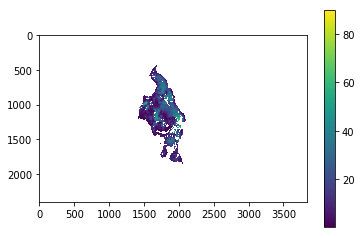

Average velocity: 16.17 m/yr
(2402, 3842)


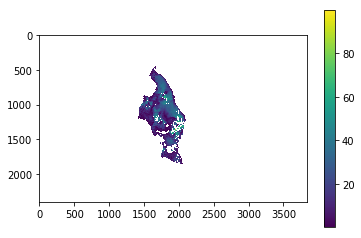

Average velocity: 18.24 m/yr
(2402, 3842)


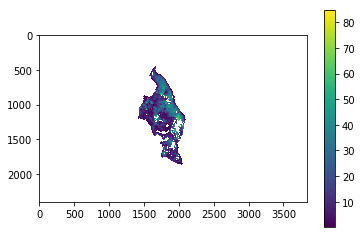

Average velocity: 17.03 m/yr
(2402, 3842)


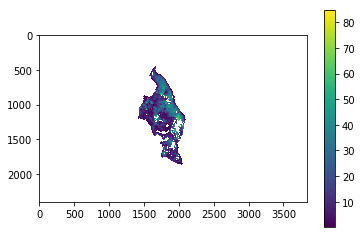

Average velocity: 17.03 m/yr


In [23]:
# conrad glacier
n_min = 50. 

c_2015 = make_gradients(path, path_out, 'conrad_2014_2015_dh_dt_filled_17_5m.tif', 
                   '140911_conrad_update_dem1_clip_5m.tif', 'img1_20150420__img2_20160417_vmap_5.0m_35px_spm2-F_vm.tif', 
                        'conrad_2014_extent_5m.tif', n_min)

c_2016 = make_gradients(path, path_out, 'conrad_2015_2016_dh_dt_filled_17_5m.tif', 
                    '20150912_conrad_ppp_dem1_clip_slave_5m.tif', 'img1_20160417__img1_20170521_vmap_5.0m_35px_spm2-F_vm.tif', 
                        'conrad_2016_extent_5m.tif', n_min)

c_2017 = make_gradients(path, path_out, 'conrad_2016_2017_dh_dt_filled_clip_5m.tif', 
                    '20160912_conrad_dem1_clip_slave_5m.tif', 'img1_20170521__img2_20180426_vmap_5.0m_35px_spm2-F_vm.tif',
                        'conrad_2016_extent_5m.tif', n_min)

c_2018 = make_gradients(path, path_out, 'conrad_2018_2017_dh_dt_5m.tif', '20170917_conrad_dem1_clip_slave_5m.tif',
                        'img1_20170521__img2_20180426_vmap_5.0m_35px_spm2-F_vm.tif', 'conrad_2016_extent_5m.tif', n_min)

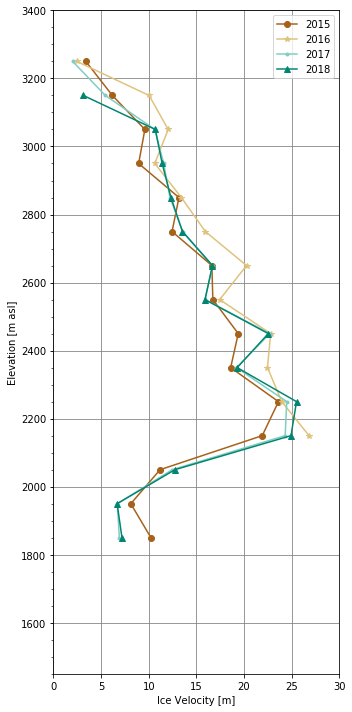

In [24]:

## Code below is a hack. It should be written as a set of functions
## when one has more time (interate over objects and names)
bin_size = 100
#glacier = 'zillmer'
## write dataframes to output
# for year in years:
#     year.to_csv(path_out + glacier + 'D_' + year + '.csv')
c_2015.to_csv(path_out + glacier + NAME + str(bin_size) + '_2015.csv')
c_2016.to_csv(path_out + glacier + NAME + str(bin_size) + '_2016.csv')
c_2017.to_csv(path_out + glacier + NAME + str(bin_size) + '_2017.csv')
c_2018.to_csv(path_out + glacier + NAME + str(bin_size) + '_2018.csv')


## make a few plots
## since function 'make_snow_gradients' returns pandas series with indexes 
## we have to extract values noted in calls to objects in plot values
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.rcParams['figure.figsize'] = 5, 10

fig, ax = plt.subplots()


ax.plot(c_2015[NAME], c_2015['Zbins'], c='#a6611a', marker='o', label='2015')
ax.plot(c_2016[NAME], c_2016['Zbins'], c='#dfc27d', marker='*', label='2016')
ax.plot(c_2017[NAME], c_2017['Zbins'], c='#80cdc1', marker='.', label='2017')
ax.plot(c_2018[NAME], c_2018['Zbins'], c='#018571', marker='^', label='2018')
ax.set_ylabel('Elevation [m asl]')


## These limits are scaled to fit all data 
## to keep scaling consistent. These can be cahnged
if NAME == 'Depth':
    ax.set_xlim([-10, 4])
    ax.set_xlabel('Height Change [m]')
else: 
    ax.set_xlim([0, 30])
    ax.set_xlabel('Ice Velocity [m]')
ax.set_ylim([1450, 3400])

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(50))
plt.grid(color='grey')

plt.tight_layout()
plt.legend()
if NAME == 'Depth':
    plt.savefig(path_out + glacier + '_height_change_on_ice.pdf', resolution=600)
else:
    plt.savefig(path_out + glacier + '_ice_velocity.pdf', resolution=600)
plt.show()

In [25]:
# # open GeoTIFF as array
# dh_dt = gdal.Open(path + dh_dt).ReadAsArray()
# dem   = gdal.Open(path + dem).ReadAsArray()
# msk   = gdal.Open(path + msk).ReadAsArray() * 1.0
# vel   = gdal.Open(path + vel).ReadAsArray() 


# #     dh_dt[dh_dt < 1000.] = np.nan
# dem[dem < 1000.] = np.nan
# vel[vel > 100.] = np.nan

# msk[msk == 0.0] = np.nan
# #     msk[msk == 1.0] = 2.0

# print(np.shape(dh_dt))
# #     print(np.shape(snow_dem))

# dh = dh_dt * msk #(msk - 1.0) *(snow_dem - dh_dt)
# vel = vel * msk
# dh[np.abs(dh) > 15] = np.nan
# #     dh[np.abs(dh) < -15] = np.nan
# #     dh[dh < 0] = np.nan

# #dh[c2018 < 1800] = np.nan

# plt.imshow(dh)
# plt.colorbar()
# plt.show()

# print('Average elevation change:', np.nanmean(dh), 'm')

# plt.imshow(vel)
# plt.colorbar()
# plt.show()
# print('Average velocity:', np.nanmean(vel), 'm/yr')


# # convert 2-d elevation and SWE arrays to 1-D vectors using ravel function
# Zvec = np.ravel(dem)
# Depthvec = np.ravel(dh)
# Velvec = np.ravel(vel)

# bins = range(1400,3700,100)

# # create pandas dataframe for elevation and height change
# df = pd.DataFrame({"Z":Zvec,"Depth":Depthvec, "v":Velvec})

# # classify the elevation data into 100 metre bins and add to the data frame 
# df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(1450, 3650, 100))

# ## get some statistics from the data
# ## this will be series which can be a pain to work with 
# ## so convert to dataframes



In [26]:

# for NAME in ['Depth','v']:
#     median = df.groupby(by='Zbins')[NAME].median()
#     iqr   = df.groupby(by='Zbins')[NAME].quantile(0.75) - df.groupby(by='Zbins')[NAME].quantile(0.25)
#     count  = df.groupby(by='Zbins')[NAME].count()

#     ## remove any values that are less than 100 values
#     ## these are series not pandas dataframes

#     ## convert series to pandas data frames instead of series

#     median = median.to_frame() 
#     iqr    = iqr.to_frame()
#     count  = count.to_frame()

#     OUT= pd.DataFrame({'D':np.array(median),'iqr': np.array(iqr),'count' : np.array(count),
#              'Zbins':np.array(df.Zbins)})

In [27]:
# ## Call function to make dataframes for plotting

# ## this sets the minimum count of a given elevation bin

# n_min = 500. 

# c_2015 = make_snow_gradients(path, path_out, 'conrad_bedem_master_5m.tif', 
#                     'conrad_2015_winter_5m.tif', 
#                     'conrad_2016_ice_msk_5m.tif', n_min)

# c_2016 = make_snow_gradients(path, path_out, 'conrad_bedem_master_5m.tif', 
#                     'conrad_2016_winter_5m.tif', 
#                     'conrad_2016_ice_msk_5m.tif', n_min)

# c_2017 = make_snow_gradients(path, path_out, 'conrad_bedem_master_5m.tif', 
#                     'conrad_2017_winter_5m.tif', 
#                     'conrad_2016_ice_msk_5m.tif', n_min)

# c_2018 = make_snow_gradients(path, path_out, 'conrad_bedem_master_5m.tif', 
#                     'conrad_2018_winter_5m.tif', 
#                     'conrad_2016_ice_msk_5m.tif', n_min)


KeyError: 'Depth'

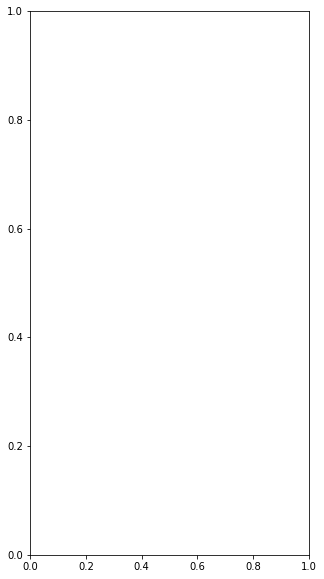

In [28]:

## Code below is a hack. It should be written as a set of functions
## when one has more time (interate over objects and names)

## write dataframes to output
c_2015.to_csv(path_out + 'conrad_2015.csv')
c_2016.to_csv(path_out + 'conrad_2016.csv')
c_2017.to_csv(path_out + 'conrad_2017.csv')
c_2018.to_csv(path_out + 'conrad_2018.csv')


## make a few plots
## since function 'make_snow_gradients' returns pandas series with indexes 
## we have to extract values noted in calls to objects in plot values
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.rcParams['figure.figsize'] = 5, 10

fig, ax = plt.subplots()


ax.plot(c_2015['Depth'], c_2015['Zbins'],'-ro', label='2015')
ax.plot(c_2016['Depth'], c_2016['Zbins'], '-g*', label='2016')
ax.plot(c_2017['Depth'], c_2017['Zbins'], '-k.', label='2017')
ax.plot(c_2018['Depth'], c_2018['Zbins'], '-b^', label='2018')
ax.set_ylabel('Elevation [m asl]')
ax.set_xlabel('Snow depth [m]')

## These limits are scaled to fit all data 
## to keep scaling consistent. These can be cahnged
ax.set_xlim([0, 5])
ax.set_ylim([1100, 3250])

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(50))
plt.grid(color='grey')

plt.tight_layout()
plt.legend()
plt.savefig(path_out + 'Conrad_snow_gradients_off_ice.pdf', resolution=600)
plt.show()

In [ ]:
## try kokanee
path = '/Volumes/Powermac_backup/lidar_cbt_analysis/kokanee/'
k_2018 = make_snow_gradients(path, path_out, '160913_Kokanee_bedem_5m.tif', 
                    '180426_kokanee_winter_5m.tif', 
                    'kokanee_2016_ice_msk_5m.tif')

In [ ]:
## make a few plots
plt.rcParams['figure.figsize'] = 5, 10
#plt.plot(c_2015.get_values(), c_2015.index.get_values(),'-ro', label='2015')
#plt.plot(c_2016.get_values(), c_2016.index.get_values(), '-g*', label='2016')
#plt.plot(c_2017.get_values(), c_2017.index.get_values(), '-k.', label='2017')
plt.plot(k_2018.get_values(), k_2018.index.get_values(), '-b^', label='2018')
plt.ylabel('Elevation [m asl]')
plt.xlabel('Snow depth [m]')
plt.tight_layout()
plt.legend()
plt.savefig('Kokanee_snow_gradients_off_ice.pdf', resolution=600)
plt.show()